### Clasificación de Noticias Usando RNN

#### Librerías

In [2]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import re
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

#### 1. Carga y Exploración de Datos

In [3]:
Df = pd.read_excel("C:/Users/USER/OneDrive - universidadean.edu.co/5. NLP/Repositorio NLP/Actividad 2/Noticias.xlsx", engine='openpyxl')
Df.drop('Columna1', axis=1, inplace=True)
Df

,Enlaces,Título,info,contenido,Etiqueta
0,https://www.eltiempo.com/agresion-contra-un-op...,Operador de grúa quedó inconsciente tras agres...,El conductor de una moto le lanzó el casco y p...,Las autoridades están buscando al conductor de...,colombia
1,https://www.eltiempo.com/archivo/documento/CMS...,"Usaquén, primera en infracciones por mal parqueo",La localidad ocupa el primer lugar en comparen...,"""Los andenes son para los peatones"", reclama e...",archivo
2,https://www.eltiempo.com/archivo/documento/CMS...,'Me atracaron y vi un arma que me heló la sang...,Un ciudadano relata cómo cuatro hombres lo rob...,A las 7 de la noche me había quedado de encont...,archivo
3,https://www.eltiempo.com/archivo/documento/CMS...,"Escoltas mal estacionados, dolor de cabeza de ...",Las zonas de restaurantes se convierten en par...,Atravesados. Eso es lo que se les pasa por la ...,archivo
4,https://www.eltiempo.com/archivo/documento/CMS...,Radicado primer proyecto que autorizaría union...,"El representante de 'la U', Miguel Gómez, dijo...",“Estamos proponiendo la figura de un contrato ...,archivo
...,...,...,...,...,...
14391,https://www.eltiempo.com/vida/viajar/una-viaje...,Una viajera pensó que la aerolínea Viva Air le...,La mujer hizo la denuncia en redes. La aerolín...,En Twitter es tendencia 'FCAS' por una denunci...,vida
14392,https://www.eltiempo.com/vida/viajar/un-dia-pe...,"Un día perfecto en Coco Cay, la isla privada d...",El proyecto Global Private Island Collection c...,La naviera internacional Royal Caribbean prese...,vida
14393,https://www.eltiempo.com/vida/viajar/visitar-b...,Barú: el paraíso colombiano abierto para todos...,Cuatro hoteles y el Aviario Nacional lanzarán ...,¿Necesita razones para ir a Barú? A menos de u...,vida
14394,https://www.eltiempo.com/vida/viajar/we-trade-...,"Con WeTrade, llega la hora LGBT a Bogotá",El 1 y 2 de noviembre se celebrará esta Feria ...,Se estima que la población LGTBI en Colombia e...,vida


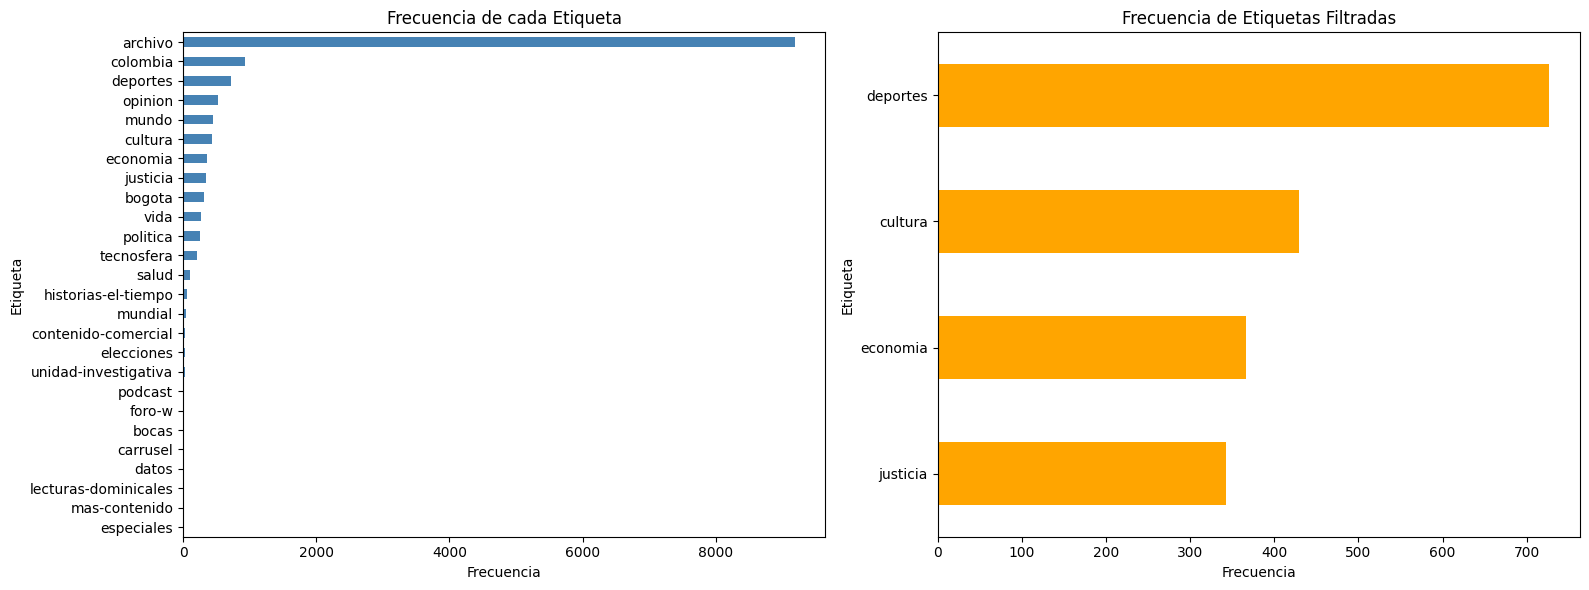

In [4]:
# Calcular las frecuencias
frecuencia_etiquetas = Df['Etiqueta'].value_counts()

# Crear los subgráficos en una sola fila
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 fila, 2 columnas

# Graficar las frecuencias generales
frecuencia_etiquetas.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Frecuencia de cada Etiqueta')
axes[0].set_xlabel('Frecuencia')
axes[0].set_ylabel('Etiqueta')
axes[0].invert_yaxis()  # Invertir el eje Y

# Filtrar etiquetas
Df_filter = Df[Df['Etiqueta'].isin(["deportes", "cultura", "economia", "justicia"])]
frecuencia_etiquetas_filter = Df_filter['Etiqueta'].value_counts()

# Graficar las frecuencias filtradas
frecuencia_etiquetas_filter.plot(kind='barh', ax=axes[1], color='orange')
axes[1].set_title('Frecuencia de Etiquetas Filtradas')
axes[1].set_xlabel('Frecuencia')
axes[1].set_ylabel('Etiqueta')
axes[1].invert_yaxis()  # Invertir el eje Y

# Ajustar diseño para evitar solapamientos
plt.tight_layout()
plt.show()



#### 2. Filtrado de Datos

In [5]:
#Eliminar contenido vacio
Df_filter = Df_filter.dropna(subset=['contenido'])

Df_filter


,Enlaces,Título,info,contenido,Etiqueta
10487,https://www.eltiempo.com/cultura/al-interior-d...,"Al interior de, aparte, roquero, rock / El len...",'Al interior de' es el reemplazo sofisticado e...,Citas: “Los crímenes de violencia sexual comet...,cultura
10488,https://www.eltiempo.com/cultura/arte-y-teatro...,Antonina Canal: 20 años de danza oriental en C...,La bailarina habló con EL TIEMPO de su trayect...,Con motivo de la celebración de los 20 años de...,cultura
10489,https://www.eltiempo.com/cultura/arte-y-teatro...,"Aparece en Holanda cuadro de Picasso, robado h...","La pintura era propiedad de un jeque saudí, Ab...","El cuadro Busto de mujer, del artista español ...",cultura
10490,https://www.eltiempo.com/cultura/arte-y-teatro...,Así será la programación del Carnaval de las A...,El evento con algunos de los artistas más repr...,"El Carnaval de las Artes, organizado en Barran...",cultura
10491,https://www.eltiempo.com/cultura/arte-y-teatro...,‘Fragmentos’ se viste de charlas y música,El lugar donde está el monumento de la artista...,"Louise du Toit, filósofa; el doctor Denis Mukw...",cultura
...,...,...,...,...,...
12467,https://www.eltiempo.com/justicia/servicios/po...,Más de 70 mil policías apoyan jornada de aisla...,Miisterio de Defensa activó dispositivo especi...,"El ministro de la Defensa, Carlos Holmes Truj...",justicia
12468,https://www.eltiempo.com/justicia/servicios/pr...,Habrá proyecto conjunto para superar la crisis...,Se revisarán “conductas antisociales” que se h...,Después de varios contrapunteos sobre la mejor...,justicia
12469,https://www.eltiempo.com/justicia/servicios/qu...,¿Qué hacer en caso de un accidente de tránsito...,EL TIEMPO y la Unilibre responden a esta y otr...,El TIempo y la Universidad Libre se aliaron pa...,justicia
12470,https://www.eltiempo.com/justicia/servicios/su...,Otorgan subsidios a tres obreros del edificio ...,También la esposa de una de las víctimas recib...,Tres trabajadores del edificio Portales Blas d...,justicia


Etiqueta
deportes    727
cultura     727
economia    727
justicia    727
Name: count, dtype: int64


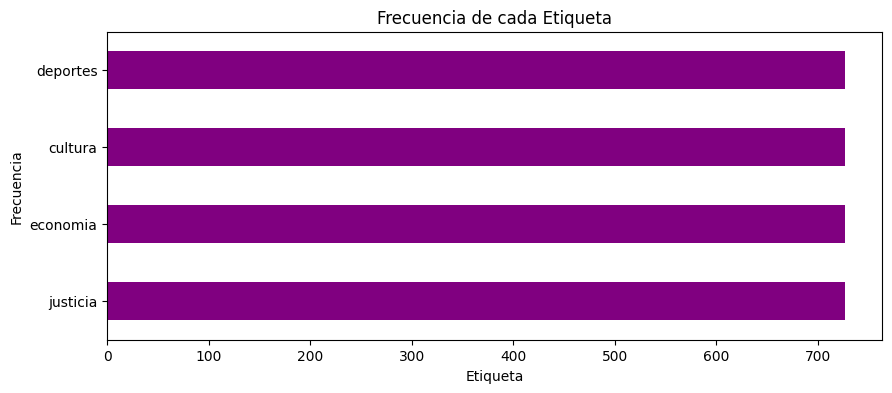

In [6]:
from sklearn.utils import resample

# Separar las clases
deportes = Df_filter[Df_filter['Etiqueta'] == 'deportes']
cultura = Df_filter[Df_filter['Etiqueta'] == 'cultura']
economia = Df_filter[Df_filter['Etiqueta'] == 'economia']
justicia = Df_filter[Df_filter['Etiqueta'] == 'justicia']

# Sobremuestreo de las clases menores
cultura_upsampled = resample(cultura, replace=True, n_samples=len(deportes), random_state=42)
economia_upsampled = resample(economia, replace=True, n_samples=len(deportes), random_state=42)
justicia_upsampled = resample(justicia, replace=True, n_samples=len(deportes), random_state=42)

# Unir los datasets
Df_pre = pd.concat([deportes, cultura_upsampled, economia_upsampled, justicia_upsampled])

#Graficar frecuencia
frecuencia_etiquetas = Df_pre['Etiqueta'].value_counts()

# Verificar el balance
print(Df_pre['Etiqueta'].value_counts())
plt.figure(figsize=(10, 4))
frecuencia_etiquetas.plot(kind='barh', color='purple')
plt.title('Frecuencia de cada Etiqueta')
plt.xlabel('Etiqueta')
plt.ylabel('Frecuencia')
plt.gca().invert_yaxis()
plt.show()


#### 3. Preprocesamiento
#### 4.División del conjunto de datos

In [7]:
Df_pre

,Enlaces,Título,info,contenido,Etiqueta
10924,https://www.eltiempo.com/deportes/automovilism...,La Fórmula 1 sigue sufriendo: aplazado el GP d...,Se debía celebrar del 12 al 14 de junio en Mon...,La organización del Grand Premio de Canadá de ...,deportes
10925,https://www.eltiempo.com/deportes/automovilism...,Al hijo de Schumacher no le disgustaría enfren...,"Mick, heredero de la dinastía del siete veces ...",Llevar el apellido Schumacher es sinónimo de g...,deportes
10926,https://www.eltiempo.com/deportes/automovilism...,Alonso y Toyota conquistan por primera vez las...,El español hizo equipo con Sébastian Buemi y e...,"Fernando Alonso, acompañado por el suizo Sébas...",deportes
10927,https://www.eltiempo.com/deportes/automovilism...,Batalla abierta por el campeonato de F1: Hamil...,Valtteri Bottas de Mercedes y Kimi Raikonen de...,El británico Lewis Hamilton logró este domingo...,deportes
10928,https://www.eltiempo.com/deportes/automovilism...,¡Qué innovadores! La atractiva propuesta para ...,En medio de las suspensiones de las carreras p...,La Fórmula 1 realizará una competición virtual...,deportes
...,...,...,...,...,...
12387,https://www.eltiempo.com/justicia/investigacio...,Cuatro departamentos han invertido menos del 3...,Contraloría dice que 54 % de recursos para inv...,Más de la mitad de la plata disponible para in...,justicia
12434,https://www.eltiempo.com/justicia/investigacio...,"Un video, prueba reina de soborno en el Tribun...",El esposo de la magistrada que había denunciad...,La Fiscalía imputó este martes cargos al secre...,justicia
12396,https://www.eltiempo.com/justicia/investigacio...,Recuerdos de un excombatiente en la Guerra de ...,El Coronel en retiro dijo que 4253 hombres hi...,Desde hace años Corea del Sur ha donado a Colo...,justicia
12182,https://www.eltiempo.com/justicia/conflicto-y-...,Hijo de 'Tirofijo' entre los nuevos disidentes...,También reaparecieron otros exjefes de las ext...,En el video de 32 minutos grabado por algunos ...,justicia


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
import spacy
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Descargar recursos necesarios
nltk.download('stopwords')

# Cargar modelo de SpaCy
nlp = spacy.load('es_core_news_sm')

# 1. Clase para Normalizar el texto
class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('spanish'))

    def normalize_text(self, text):
        text = text.lower()
        text = re.sub(r"[.,!?]", r" \g<0> ", text)
        text = re.sub(r"[\W\d_]+", " ", text)
        text = " ".join([word for word in text.split() if word not in self.stop_words])
        return text.strip()

    def transform(self, X, **kwargs):
        return X.apply(self.normalize_text)

    def fit(self, X, y=None, **kwargs):
        return self

# 2. Clase para Lematizar el texto
class TextLemmatizer(BaseEstimator, TransformerMixin):
    def transform(self, X, **kwargs):
        return X.apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

    def fit(self, X, y=None, **kwargs):
        return self

# 3. Clase para Tokenizar el texto
class TextTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer()
        self.max_sequence_len = 0

    def fit(self, X, y=None):
        self.tokenizer.fit_on_texts(X)
        self.max_sequence_len = max([len(x.split()) for x in X])
        return self

    def transform(self, X, **kwargs):
        sequences = self.tokenizer.texts_to_sequences(X)
        self.sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=self.max_sequence_len)
        return self.sequences

    def get_word_index(self):
        return self.tokenizer.word_index

    def get_sequences(self):
        return self.sequences

# 4. Clase para Codificar las etiquetas
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, y):
        self.label_encoder.fit(y)
        return self

    def transform(self, y, **kwargs):
        labels_encoded = self.label_encoder.transform(y)
        return tf.keras.utils.to_categorical(labels_encoded, num_classes=len(self.label_encoder.classes_))

# 5. Definir el Pipeline de procesamiento de texto
text_pipeline = Pipeline([
    ('normalizer', TextNormalizer()),
    ('lemmatizer', TextLemmatizer()),
    ('tokenizer', TextTokenizer())
])

# Configurar el tamaño máximo de secuencia
max_sequence_len = 300
text_pipeline.named_steps['tokenizer'].max_sequence_len = max_sequence_len

# 6. Extraer las oraciones y etiquetas del DataFrame
sentences = Df_pre['contenido']
labels = Df_pre['Etiqueta'].tolist()

# 7. Normalizar, lematizar y tokenizar las oraciones
X_processed = text_pipeline.fit_transform(sentences)
sequences = text_pipeline.named_steps['tokenizer'].get_sequences()

# 8. Codificar las etiquetas
y_encoder = LabelEncoderTransformer()
y = y_encoder.fit_transform(labels)

# 9. Configurar validación cruzada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Variables para almacenar métricas globales
rnn_accuracies = []
y_true_all = []
y_pred_all = []


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 5. RNN

In [13]:
# Modelo SimpleRNN adicional con validación cruzada
learning_rate = 0.0001

# Métricas acumuladas
rnn_accuracies = []

for train_idx, val_idx in kfold.split(sequences, np.argmax(y, axis=1)):
    # Dividir los datos
    X_train_cv, X_val_cv = sequences[train_idx], sequences[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]

    # Definir el modelo
    model_rnn = Sequential([
        Embedding(input_dim=len(text_pipeline.named_steps['tokenizer'].get_word_index()) + 1,
                  output_dim=128,
                  input_length=max_sequence_len),
        SimpleRNN(80, return_sequences=True, dropout=0.2),
        SimpleRNN(80, dropout=0.2),
        Dense(len(y_encoder.label_encoder.classes_), activation='softmax')
    ])

    model_rnn.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Entrenar el modelo con verbose=1 para mostrar las métricas de cada época
    history = model_rnn.fit(
        X_train_cv, y_train_cv,
        epochs=20,  # Reducir las épocas para hacerlo más legible
        batch_size=64,
        validation_data=(X_val_cv, y_val_cv),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)],
        verbose=1  # Cambiar verbose a 1 para mostrar el progreso del entrenamiento
    )

    # Evaluar el modelo
    val_accuracy = model_rnn.evaluate(X_val_cv, y_val_cv, verbose=0)[1]
    rnn_accuracies.append(val_accuracy)

# Imprimir la precisión promedio del modelo SimpleRNN
print(f"SimpleRNN Accuracy promedio: {np.mean(rnn_accuracies)}")
model_rnn.summary()



c:\Users\USER\miniconda3\envs\entorno_npl_ean_py3.10\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.2920 - loss: 1.4051 - val_accuracy: 0.4880 - val_loss: 1.2969
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.4220 - loss: 1.2708 - val_accuracy: 0.6237 - val_loss: 1.0349
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.7028 - loss: 0.8930 - val_accuracy: 0.7732 - val_loss: 0.7112
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.8869 - loss: 0.4997 - val_accuracy: 0.8333 - val_loss: 0.5395
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.9510 - loss: 0.2719 - val_accuracy: 0.8625 - val_loss: 0.4430
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.9752 - loss: 0.1714 - val_accuracy: 0.8797 - val_loss: 0.3771
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.9866 - loss: 0.1049 - val_accuracy: 0.8780 - val_loss: 0.3936
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.9831 - loss: 0.0924 - val_accuracy: 0.8763 - val_lo

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 2839, 128)      │     4,410,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 2839, 80)       │        16,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 80)             │        12,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           324 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,320,878 (50.82 MB)

 Trainable params: 4,440,292 (16.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,880,586 (33.88 MB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 356ms/step
SimpleRNN Accuracy promedio (Validación cruzada): 0.8867
Accuracy global: 0.9053
Precision global (ponderada): 0.9055
Recall global (ponderada): 0.9053
F1-score global (ponderado): 0.9054

Reporte de Clasificación:
               precision    recall  f1-score   support

     cultura       0.89      0.90      0.89       145
    deportes       0.86      0.85      0.85       145
    economia       0.97      0.96      0.97       146
    justicia       0.90      0.91      0.91       145

    accuracy                           0.91       581
   macro avg       0.91      0.91      0.91       581
weighted avg       0.91      0.91      0.91       581



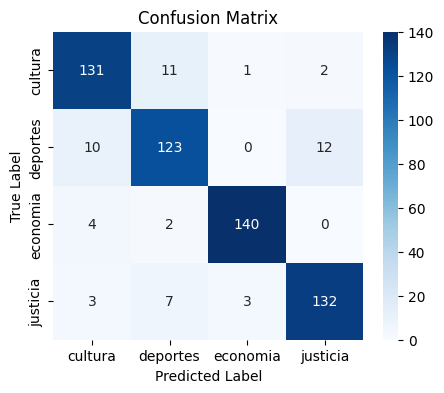

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 2839, 128)      │     4,410,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 2839, 80)       │        16,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 80)             │        12,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           324 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,320,878 (50.82 MB)

 Trainable params: 4,440,292 (16.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,880,586 (33.88 MB)

In [48]:
# Inicializar las listas al inicio de la ejecución
y_true_all = []
y_pred_all = []

# Evaluar el modelo en cada iteración de validación cruzada
y_pred_prob = model_rnn.predict(X_val_cv)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val_cv, axis=1)

# Guardar métricas y predicciones globales
rnn_accuracies.append(accuracy_score(y_true, y_pred))
y_true_all.extend(y_true)
y_pred_all.extend(y_pred)

# Calcular métricas generales
accuracy_global = accuracy_score(y_true_all, y_pred_all)
precision_global = precision_score(y_true_all, y_pred_all, average='weighted')
recall_global = recall_score(y_true_all, y_pred_all, average='weighted')
f1_global = f1_score(y_true_all, y_pred_all, average='weighted')

# Reportar métricas generales
print(f"SimpleRNN Accuracy promedio (Validación cruzada): {np.mean(rnn_accuracies):.4f}")
print(f"Accuracy global: {accuracy_global:.4f}")
print(f"Precision global (ponderada): {precision_global:.4f}")
print(f"Recall global (ponderada): {recall_global:.4f}")
print(f"F1-score global (ponderado): {f1_global:.4f}")

# Reporte de clasificación
report_rnn = classification_report(y_true_all, y_pred_all, target_names=y_encoder.label_encoder.classes_)
print("\nReporte de Clasificación:\n", report_rnn)

# Matriz de confusión global
conf_matrix_rnn = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_rnn, annot=True, cmap='Blues', fmt='g',
            xticklabels=y_encoder.label_encoder.classes_,
            yticklabels=y_encoder.label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Resumen del modelo
model_rnn.summary()



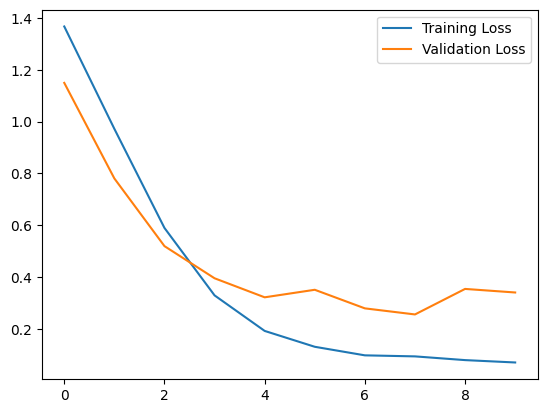

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()